In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

from pygsp import graphs

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SAVE = True
SEED = 0

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)

Exps = [{'type': 'Rand'},
        {'type': 'J', 'first': True, 'params': 4},
        {'type': 'BL', 'first': True, 'params': 16},
        {'type': 'BL', 'first': True, 'params': 32},
        {'type': 'BL', 'first': True, 'params': 4},
        {'type': 'DW'},
       ]

# Signal parameters
K = 3
n_signals = 100
n_p = 0.1

# Graph parameters
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

# Create graph
G = ds.create_graph(Gs, SEED)
A = G.W.todense()

In [3]:
# Create filter H and decoder
hs = np.random.rand(K)
hs /= np.sum(hs)
h_params = {'type': 'FixedH', 'S': 'A', 'hs': hs, 'H_norm': True}
H = utils.create_filter(A, h_params)

# Model parameters
fts = 150
epochs = 1500
lr = 0.001

H2 = H.dot(H.T)
H_norm = H/np.linalg.norm(H, axis=0)
H2_norm = H_norm.T.dot(H_norm)
H2_norm[H2_norm>1] = 1
Z = 1-np.arccos(H2_norm)/np.pi
E_JJ = 0.5*Z*(H2)

# Compute needed matrices
for exp in Exps:
    if exp['type'] == 'J':
        exp['Lambda'], exp['V'] = utils.ordered_eig(E_JJ)
    elif exp['type'] == 'BL':
        exp['Lambda'], exp['V'] = utils.ordered_eig(H)    

In [4]:
err_norm = np.zeros((len(Exps), n_signals, epochs))
start_time = time.time()
for i in range(n_signals):
    dec = GraphDecoder(fts, H, scale_std=1)
    for j, exp in enumerate(Exps):
        if exp['type'] == 'Rand':
            x = np.random.randn(G.N)
            x /= np.linalg.norm(x)
        elif exp['type'] == 'DW':
            x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.MEDIAN, K, coefs=hs)
            x_dw.to_unit_norm()
            x = x_dw.x
        else:
            x = ds.bandlimited_signal(exp['Lambda'], exp['V'],
                                      exp['params'], exp['first'])
        x_n = ds.GraphSignal.add_noise(x, n_p)
        model = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
        _, err_norm[j, i], _ = model.fit(x_n, x)
    print(i, end=' ')
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
--- 17.642326299349467 minutes ---


In [5]:
# np.save('../results/signal_influence/sig_inf_H_norm_1500epochs',err_norm)
# err_norm = np.load('../results/signal_influence/sig_inf_H_norm_1500epochs.npy')

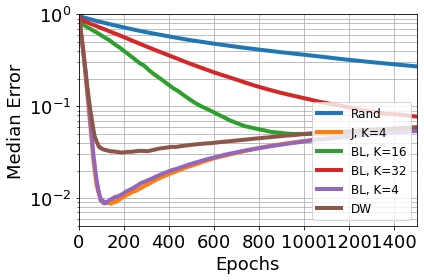

In [6]:
# Create legend
leg = []
for j, exp in enumerate(Exps):
    txt = exp['type']
    if exp['type'] not in ['Rand', 'DW']:
        if exp['first']:
            K_txt = str(exp['params'])
        else:
            K_txt = str(-exp['params'])
        txt += ', K=' + K_txt
    leg.append(txt)

# Plots Median Error
med_mse = np.median(err_norm, axis=1)

fig = plt.figure()
plt.semilogy(med_mse.T, linewidth=4)
plt.legend(leg, prop={'size': 12}, loc='lower right')
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([5e-3, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()



if SAVE:
    path = '../results/signal_influence/'
    # fig.savefig(path + 'sig_inf_H_norm_1500epochs.eps')
    # np.save(path + 'sig_inf_H_norm_1500epochs',err_norm)

In [7]:
plt.show()